# Data Analysis
Autor: HS

### Read the data

In [44]:
from pyspark.sql import SparkSession

# create sparkSession
spark = SparkSession.builder.appName("HadoopReadExample").getOrCreate()

# path to the data
path = "hdfs://namenode:9000/reddits/"
path_manip = "hdfs://namenode:9000/reddits_manipulated/"

# read data
dframe = spark.read.csv(path + "*.csv", inferSchema=True, header=True)
dframe_manip = spark.read.csv(path_manip + "*.csv", inferSchema=True, header=True)

rows = dframe.collect()
rows_manip = dframe_manip.collect()

### Create a dataframe with title, content and subreddit as columns

In [45]:
# original data
import json
import pandas as pd

data_rows = []

# extract data for title, content and subreddit
for row in rows:
    data = json.loads(row[0])
    title = data["Titel"]
    content = data["Inhalt"]
    subreddit = data["Subreddit"]

    data_rows.append({"title": title, "content": content, "subreddit": subreddit})
    
#add data to dataframe
df = pd.DataFrame(data_rows)

#drop duplicates
df = df.drop_duplicates()
    
# print dataframe
print(df.head(10))

                                               title  \
0  I Watched The Wild for the first time and its ...   
1  Hi. Im looking for Pet Pegasus and Once Upon A...   
2                       Looking for Natural White Gi   
3                                             Caught   
4                                      Upvote me plz   
5                      beware of this Vinted seller!   
6  Community DLC Smash Roster - EarthBound, Ice C...   
7  [vscode jupyter] How to hide code/input of the...   
8  Any idea why my gamepass app doesnt show Cloud...   
9  It's a difficult Father's day for me but…– Dav...   

                                             content          subreddit  
0  Oh and i don’t want to see Koala’s face holy s...       Schaffrillas  
1                                                     MonopolyGoTrading  
2  Hello! First time poster, long time lurker her...             karate  
3                                                       cuckik_again345  
4            

In [46]:
# manipulated data
import json
import pandas as pd

data_rows = []

# extract data for title, content and subreddit
for row in rows_manip:
    data = json.loads(row[0])
    title = data["Titel"]
    content = data["Inhalt"]
    subreddit = data["Subreddit"]

    data_rows.append({"title": title, "content": content, "subreddit": subreddit})
    
#add data to dataframe
df_manip = pd.DataFrame(data_rows)

#drop duplicates
df_manip = df_manip.drop_duplicates()
    
# print dataframe
print(df_manip.head(10))

                                               title  \
0  watched wild first time shockingly bad ripped ...   
1  hi im looking pet pegasus upon time dont extra...   
2                           looking natural white gi   
3                                             caught   
4                                         upvote plz   
5                               beware vinted seller   
6  community dlc smash roster earthbound ice clim...   
7             [ vscode jupyter ] hide codeinput cell   
8  idea gamepass app doesnt show cloud streaming ...   
9      difficult fathers day davido goes memory lane   

                                             content          subreddit  
0   oh dont want see koalas face holy shit cgi awful       Schaffrillas  
1                                                     MonopolyGoTrading  
2  hello first time poster long time lurker ive p...             karate  
3                                                       cuckik_again345  
4            

### Show most active subreddits

In [63]:
#show most active subreddits
df['subreddit'].value_counts().head(20)

subreddit
AskReddit             133
cuckik_again345        68
EasyMakeMoney2023      65
diablo4                53
teenagers              52
udemyfreebies          51
PokemonGoRaids         36
NoiseProtest           28
AutoNewspaper          28
temu                   26
fut                    26
Temu_referral_help     26
KGBTR                  25
Market76               25
MeetPeople             25
pics                   24
TemuHelp               24
FreeKarma4You          23
SabahHaberiTR          23
NoStupidQuestions      22
Name: count, dtype: int64

### Choose a subreddit and show posts

In [52]:
#choose subreddit
subreddit = "sportsnewstoday"

#show new posts
df[df["subreddit"]==subreddit]

,title,content,subreddit
104,Why 'unicorns' and retention could make Patrio...,,sportsnewstoday
7229,"I put additional pressure on myself, I didn't ...",,sportsnewstoday
8003,Coventry City transfer boost as Leicester City...,,sportsnewstoday
8908,The Islanders must determine whether Barzal is...,,sportsnewstoday
11144,Nick Kyrgios handed a very difficult projected...,,sportsnewstoday
12107,Newcastle United star Joelinton reflects on 'd...,,sportsnewstoday
17506,Jan Lennard Struff vs Frances Tiafoe Predictio...,,sportsnewstoday
19514,Tottenham firmly in the mix to sign midfield p...,,sportsnewstoday
21912,Iga looking EAGER - Australian Open TV,,sportsnewstoday
22434,IND vs WI: Ajinkya Rahane To Join Leicestershi...,,sportsnewstoday


### Wordcloud from chosen subreddit

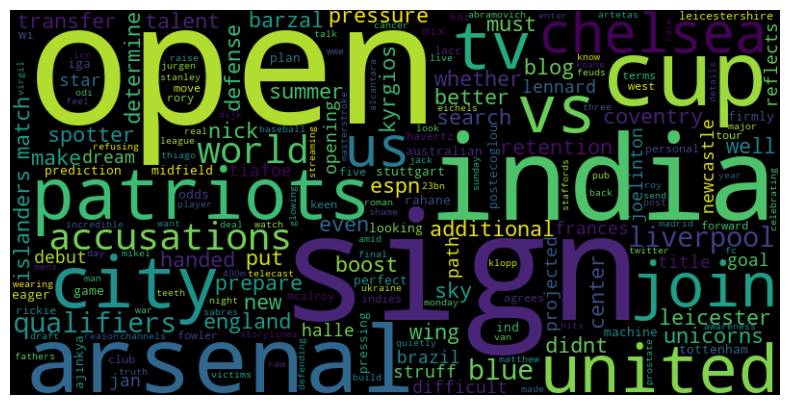

In [53]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#choose subreddit or take all subreddits
subdf = df_manip[df_manip["subreddit"]==subreddit] # specific subreddit
#subdf = df_manip # all subreddits

# combine text from title and content
text = ' '.join(subdf['title']) + ' ' + ' '.join(subdf['content'])

# create wordcloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# show wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment Analysis

In [54]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')  # Lade den Sentiment-Analyse-Lexikon aus NLTK

from nltk.sentiment import SentimentIntensityAnalyzer

# create SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# load dataframe
subdf = df[df["subreddit"]==subreddit]

# add new column for sentiment
subdf['Sentiment'] = subdf[['title', 'content']].apply(lambda row: sia.polarity_scores(row['title'] + " " + row['content'])['compound'], axis=1)

#show top 20 results
subdf.head(20)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipykernel_832/2562270634.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['Sentiment'] = subdf[['title', 'content']].apply(lambda row: sia.polarity_scores(row['title'] + " " + row['content'])['compound'], axis=1)


,title,content,subreddit,Sentiment
104,Why 'unicorns' and retention could make Patrio...,,sportsnewstoday,0.5267
7229,"I put additional pressure on myself, I didn't ...",,sportsnewstoday,-0.4614
8003,Coventry City transfer boost as Leicester City...,,sportsnewstoday,0.6705
8908,The Islanders must determine whether Barzal is...,,sportsnewstoday,0.0000
11144,Nick Kyrgios handed a very difficult projected...,,sportsnewstoday,-0.4201
12107,Newcastle United star Joelinton reflects on 'd...,,sportsnewstoday,0.4215
17506,Jan Lennard Struff vs Frances Tiafoe Predictio...,,sportsnewstoday,0.0000
19514,Tottenham firmly in the mix to sign midfield p...,,sportsnewstoday,0.5719
21912,Iga looking EAGER - Australian Open TV,,sportsnewstoday,0.4995
22434,IND vs WI: Ajinkya Rahane To Join Leicestershi...,,sportsnewstoday,0.2960


In [55]:
#calculate average sentiment
average_sentiment = subdf['Sentiment'].mean()

#print result
print("Durchschnittliches Sentiment:", average_sentiment)

Durchschnittliches Sentiment: 0.03605454545454546


In [56]:
#get statistics about sentiment column
sentiment_stats = subdf['Sentiment'].describe()

#print results
print("Sentiment-Statistik:")
print(sentiment_stats)

Sentiment-Statistik:
count    22.000000
mean      0.036055
std       0.422127
min      -0.836000
25%      -0.283125
50%       0.000000
75%       0.421500
max       0.670500
Name: Sentiment, dtype: float64


### Top 10 and Bottom 10 Subreddits per Sentiment

In [57]:
#count subreddits and select only those with more than 10 new posts
subreddit_counts = df['subreddit'].value_counts()
subreddits = subreddit_counts[subreddit_counts > 10]
subdf = df_manip[df_manip['subreddit'].isin(subreddits.index)]

# add column for sentiment
subdf['Sentiment'] = subdf[['title', 'content']].apply(lambda row: sia.polarity_scores(row['title'] + " " + row['content'])['compound'], axis=1)

#calculate average sentiment
subreddit_sentiment_avg = subdf.groupby('subreddit')['Sentiment'].mean()

# sort subreddits
sorted_subreddit_sentiment = subreddit_sentiment_avg.sort_values(ascending=False)

# top 10 subreddits
top_10_subreddits = sorted_subreddit_sentiment.head(10)

# bottom 10 subreddits
bottom_10_subreddits = sorted_subreddit_sentiment.tail(10)

# show results
print("Beste 10 Subreddits:")
print(top_10_subreddits)
print("")
print("Schlechteste 10 Subreddits:")
print(bottom_10_subreddits)

Beste 10 Subreddits:
subreddit
HANITSYPRODUCTS         0.698655
TEMU_Official           0.688733
buildapc                0.622874
Audiosurf2_Community    0.615930
EasyMakeMoney2023       0.597769
MeetPeople              0.596596
pcmasterrace            0.498588
MakeNewFriendsHere      0.490261
relationship_advice     0.431963
FreeKarma4All           0.310367
Name: Sentiment, dtype: float64

Schlechteste 10 Subreddits:
subreddit
BreakingInformation   -0.132464
BreakingNews24hr      -0.147842
Market76              -0.171164
Trendinuk             -0.210908
OnePiece              -0.215536
AskDocs               -0.355764
rameenu755            -0.389736
limjk87               -0.432033
NoiseProtest          -0.542300
oplpii9               -0.554718
Name: Sentiment, dtype: float64


/tmp/ipykernel_832/958429914.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['Sentiment'] = subdf[['title', 'content']].apply(lambda row: sia.polarity_scores(row['title'] + " " + row['content'])['compound'], axis=1)


### Topic Modeling

In [58]:
import gensim
from gensim import corpora

#choose subreddit or select all
subdf = df_manip[df_manip["subreddit"]==subreddit]
#subdf = df_manip

#create lists
title_list = subdf['title'].tolist()
content_list = subdf['content'].tolist()
texts = title_list
texts.extend(content_list)
texts = [[word for word in doc.split()] for doc in texts]

# create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# train model
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)

# extract topics and words
topics = lda_model.print_topics(num_words=10)

#print results
for topic_id, topic in topics:
    topic_words = topic.split("+")
    topic_words = [word.split("*")[1].replace('"', '').strip() for word in topic_words]
    topic_words_str = ", ".join(topic_words)
    print(f"Topic {topic_id + 1}: {topic_words_str}")

Topic 1: open, sign, arsenal, 2023, tv, iga, cup, must, us, put
Topic 2: wearing, baseball, cancer, day, major, prostate, awareness, keen, dream, celebrating
Topic 3: arsenal, race, player, madrid, incredible, enter, real, want, sign, looking
Topic 4: city, united, chelsea, accusations, know, mikel, artetas, truth, build, man
Topic 5: cup, india, qualifiers, world, tv, mens, icc, details, 2023, channels
Topic 6: sign, fc, hits, virgil, keane, roy, amid, dijk, watch, storylines
Topic 7: 2023, vs, open, jan, lennard, odds, prediction, struff, stuttgart, wi
Topic 8: open, us, teeth, staffords, matthew, glowing, talk, twitter, city, talent
Topic 9: liverpool, jurgen, made, klopp, thiago, feuds, look, quietly, monday, masterstroke
Topic 10: patriots, could, defense, england, blog, even, new, better, retention, unicorns


### Question-Answering-System

In [61]:
from transformers import pipeline

subdf = df[df["subreddit"]==subreddit]

text = ' '.join([f"{title} {content}" for title, content in zip(subdf['title'], subdf['content'])])
qa = pipeline(task="question-answering", model="distilbert-base-uncased-distilled-squad")

answer = qa(question="Who is trainer of Liverpool football club?", context=text)

print(answer)

{'score': 0.9885324239730835, 'start': 1576, 'end': 1588, 'answer': 'Jurgen Klopp'}


In [62]:
#show context
range_of_context_lower = answer['start']-200 if answer['start']-200 >= 0 else 0
range_of_context_upper = answer['end']+300
context = text[range_of_context_lower:range_of_context_upper]
print(context)

 ODI World Cup Qualifiers 2023 Live Streaming In India Details World Cup Qualifiers Telecast India TV Channels  Virgil van Dijk hits back at Roy Keane amid 'pub defending' accusations - Liverpool FC  Jurgen Klopp has quietly made Thiago Alcantara masterstroke before final year at Liverpool  Major League Baseball celebrating Father’s Day by wearing blue to raise awareness for prostate cancer  Matthew Stafford’s glowing teeth at the US Open were the talk of Twitter 
